Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


Exported /home/adelgior/workspace/images/000011_gt_51894.png
Exported /home/adelgior/workspace/images/000012_gt_427051.png
Exported /home/adelgior/workspace/images/000013_gt_82990.png
Exported /home/adelgior/workspace/images/000014_gt_147839.png
Exported /home/adelgior/workspace/images/000015_gt_369521.png
Exported /home/adelgior/workspace/images/000016_gt_215222.png
Exported /home/adelgior/workspace/images/000017_gt_329515.png
Exported /home/adelgior/workspace/images/000018_gt_404751.png
Exported /home/adelgior/workspace/images/000019_gt_256787.png
Exported /home/adelgior/workspace/images/000020_gt_489267.png


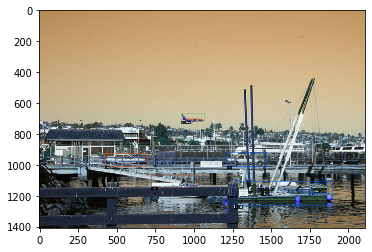

In [2]:
import numpy as np
from PIL import Image
from detectron2.data import MetadataCatalog, build_detection_train_loader
from detectron2.utils.visualizer import Visualizer

from export_proposal_helpers import get_maskrcnn_cfg, cv2_imshow, FigExporter

cfg = get_maskrcnn_cfg()
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
scale = 2.0


train_data_loader = build_detection_train_loader(cfg)
exporter = FigExporter()
n_images_to_export = 10
i = 0
done = False
for batch in train_data_loader:
    for per_image in batch:
        # Pytorch tensor is in (C, H, W) format
        img = per_image["image"].permute(1, 2, 0)
        if cfg.INPUT.FORMAT == "BGR":
            img = img[:, :, [2, 1, 0]]
        else:
            img = np.asarray(Image.fromarray(img, mode=cfg.INPUT.FORMAT).convert("RGB"))

        visualizer = Visualizer(img, metadata=metadata, scale=scale)
        visualizer._default_font_size = visualizer._default_font_size * 1.5
        target_fields = per_image["instances"].get_fields()
        labels = [metadata.thing_classes[i] for i in target_fields["gt_classes"]]
        vis = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=None,
            keypoints=None,
        )
        cv2_imshow(vis.get_image()[:, :, ::-1])
        exporter.export_gcf(tag='gt_' + str(per_image["image_id"]))
        i += 1
        if i >= n_images_to_export:
            break
    if i >= n_images_to_export:
        break
